In [1]:

import numpy as np
import time
from scipy import linalg #* Solver of matrix equations
import scipy.integrate as integrate #* Numerical integration
from tqdm import tqdm
#* Define constants
light_speed, mu0, eps0 = 299792458., 4*np.pi*1e-7, 8.854e-12
frequency = 1e6 * 146
omega = 2 * np.pi * frequency
incident_voltage = 10
c = light_speed
#* set geometry of antenna
element_position = np.array([[0,0,0],[0,0.312,0],[0,0.447,0],[0,0.699,0],[0,1.05,0],[0,1.482,0],[0,1.986,0],[0,2.553,0],[0,3.168,0]],dtype=float)
element_length = np.array([1.038, 0.955, 0.956, 0.932, 0.916, 0.906, 0.897, 0.891, 0.887])
wire_radius = np.array([3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3, 3.175e-3])
source_position = np.array([element_position[1]], dtype = float)

#! Spatial resolution
res_min, res_max, dres = 1e2, 4e3, 2e2
N = int((res_max - res_min)/dres)
res = np.linspace(res_min, res_max, N)
delta_z = light_speed / frequency / res
print(len(delta_z), max(delta_z), min(delta_z))
def calculate_positions(element_length, element_position, frequency, delta_z):
    #* Start timing the execution
    start_time = time.time()
    
    # Calculate some parameters of the system
    wavelength = light_speed / frequency
    wavenumber = 2 * np.pi * frequency / light_speed
    
    # Calculate number of segments on each element
    element_num = np.zeros(len(element_length), dtype=int)
    for i in range(len(element_length)):
        element_num[i] = int(element_length[i] / delta_z) if int(element_length[i] / delta_z) % 2 != 0 else int(element_length[i] / delta_z) + 1
    
    # Define list of positions, where R[m][i] - the position of i-th segment on m-th element
    R_block = [0] * len(element_num)
    for m in range(len(element_num)):
        R_block[m] = np.zeros((element_num[m], 3))
        for i in range(len(R_block[m])):
            R_block[m][i, 0] = element_position[m][0]
            R_block[m][i, 1] = element_position[m][1]
            R_block[m][i, 2] = element_position[m][2] - element_num[m] * delta_z / 2 + delta_z * (1/2 + i)
    
    # Deploying a block matrix (reshape)
    num_elements = sum(element_num)
    R = np.zeros((num_elements, 3), dtype=float)
    cum_n = np.append(0, np.cumsum(element_num))
    for i in range(len(cum_n) - 1):
        R[cum_n[i]:cum_n[i + 1]] = R_block[i]
    
    # Calculate execution time
    execution_time = time.time() - start_time
    
    return element_num, R_block, R, execution_time

# Green function for Helmholtz equation
def Green_function(r_n, r_m, omega):
    rnm = np.linalg.norm(r_m-r_n, ord = 2)
    return 1j * omega * mu0/(4*np.pi)  * np.exp(-1j * omega/c * rnm)/rnm

# Derivatives for Green function, divided by k squared
def derGreen_function(r_n, r_m, omega):
    rnm = np.linalg.norm(r_m-r_n, ord = 2)
    dz, k = r_m[2] - r_n[2], omega/c
    return 1j/(4*np.pi * omega * eps0) * dz * (1 + 1j * k * rnm)  * np.exp(-1j * k * rnm)/(rnm ** 3)

def derderGreen_function(r_n, r_m, omega):
    rnm = np.linalg.norm(r_m-r_n, ord = 2)
    dz, k = r_m[2] - r_n[2], omega/c
    # Formula from Shuras MIND
    poly_part = 2 * dz ** 2 + 3j * k * dz ** 2 * rnm - (1-k**2 * dz ** 2) * rnm ** 2 -\
        1j * k * rnm ** 3 + k ** 2 * rnm ** 4
    # Formula from Indian masters
    # poly_part = 3 * dz ** 2 + 3j * k * dz ** 2 * rnm - (1-k**2 * dz ** 2) * rnm ** 2 -\
    #     1j * k * rnm ** 3 + k ** 2 * rnm ** 4
    return poly_part * 1j * omega * mu0/(4 * np.pi * k ** 2 * rnm ** 5) * np.exp(-1j * k * rnm)

# Calculating impedance coefficient using single quad approximation
def Zmn_single(r_n, r_m, omega, dz, wire_radius):
    # Creating function to integrate along the wire using collacations on surface
    ReZGreen_function = lambda z: Green_function(
        np.array([r_n[0], r_n[1], z]), 
        r_m + np.array([0, wire_radius, 0]), omega).real
    ImZGreen_function = lambda z: Green_function(
        np.array([r_n[0], r_n[1], z]), 
        r_m + np.array([0, wire_radius, 0]), omega).imag
    ZderGreen_function = lambda z:derGreen_function(
        np.array([r_n[0], r_n[1], z]), 
        r_m + np.array([0, wire_radius, 0]), omega)
    
    # Calculate to part of matrix
    Z_1 = integrate.quad(ReZGreen_function, r_n[2]-dz/2, r_n[2]+dz/2)[0] + 1j * integrate.quad(ImZGreen_function, r_n[2]-dz/2, r_n[2]+dz/2)[0]
    Z_2 = ZderGreen_function(r_n[2] + dz/2) - ZderGreen_function(r_n[2] - dz/2)
    return Z_1 + Z_2
            
            
def calculate_impedance_Pocklington (R, element_num, wire_radius, delta_z, omega):
    #* Start timing the execution
    start_time = time.time()
    #* Compute block matrix of impedance
    impedance_block = []
    for m in range(0, len(R)):
        impedance_row = []
        #* Filling the block using its teplitz structure
        for n in range (0, len(R)):
            impedance_mn = np.zeros((len(R[m]), len(R[n])), dtype = complex)
            for i in range (len(R[m]) + len(R[n])):
                impedance_mn[max(0, len(R[m])-i-1), max(0, i-len(R[m]))] = Zmn_single(R[n][max(0, i-len(R[m]))], R[m][max(0, len(R[m])-i-1)], omega, delta_z, wire_radius[m])
                for k in range (min( min(len(R[m]), len(R[n])), i+1, len(R[m]) + len(R[n]) - i)):
                    impedance_mn[max(0, len(R[m])-i-1) + k, max(0, i-len(R[m])) + k] = impedance_mn[max(0, len(R[m])-i-1), max(0, i-len(R[m]))]
            impedance_row.append(impedance_mn)
        impedance_block.append(impedance_row)
        
    #* Deploying a block matrix (reshape)
    num_elements = sum(element_num)
    impedance = np.zeros((num_elements, num_elements), dtype = complex)
    cum_n = np.append(0, np.cumsum(element_num))
    for i in range (len(cum_n)-1):
        for j in range (len(cum_n)-1):
            impedance[cum_n[i]:cum_n[i+1], cum_n[j]:cum_n[j+1]] = impedance_block[i][j]
    
    #* Calculate execution time
    execution_time = time.time() - start_time
    return impedance, execution_time

def calculate_voltage_Pocklington (R, element_num, source_position, driven_voltage, delta_z) :
    # Calculate execution time
    start_time = time.time()
    
    field_block = []
    for m in range (len(R)):
        field_row = np.zeros(len(R[m]))
        for i in range (len(R[m])):
            for k in range(len(source_position)):
                if all(source_position[k] == R[m][i,:]) :
                    field_row[i] = (driven_voltage / delta_z)
        field_block.append(field_row)
    #* Deploying a block matrix (reshape)
    num_elements = sum(element_num)
    field = np.zeros((num_elements), dtype = float)
    cum_n = np.append(0, np.cumsum(element_num))
    for i in range (len(cum_n)-1):
        field[cum_n[i]:cum_n[i+1]] = field_block[i]
        
    # Calculate execution time
    execution_time = time.time() - start_time
    
    return field, execution_time

19 0.02053373 0.0005133432500000001


In [ ]:
elements_of_mom = np.empty(len(delta_z))
time_positions, time_impedance, time_field = np.empty(len(delta_z)), np.empty(len(delta_z)), np.empty(len(delta_z))
time_equation, time_dp = np.empty(len(delta_z)), np.empty(len(delta_z))

for i in tqdm(range (len(delta_z))):
    
    #* Calculate some parametres of system
    wavelength, wavenumber = light_speed / frequency, omega / light_speed
    element_num, R_block, R, time_calculate_positions = calculate_positions(element_length, element_position, frequency, delta_z[i])
    impedance, time_calculate_impedance = calculate_impedance_Pocklington(R_block, element_num, wire_radius, delta_z[i], omega)
    incident_field, time_calculate_field = calculate_voltage_Pocklington(R_block, element_num, source_position, incident_voltage, delta_z[i])
    
    start_time = time.time()
    current = np.linalg.solve(impedance, incident_field)
     #* Deploying a block matrix (reshape)
    num_elements = sum(element_num)
    
    current_block = []
    cum_n = np.append(0, np.cumsum(element_num))
    for m in range (len(cum_n)-1):
        current_block.append(current[cum_n[m]:cum_n[m+1]])
    time_matrix_equation = time.time() - start_time
     
    start_time = time.time()
    E = [0]*len(element_length)
    for m in range (len(element_length)):
        z0 = np.arange(element_num[m]) * delta_z[i] - element_length[m]/2
        Ei = lambda phi : np.sum(current_block[m]*np.exp(1j*wavenumber*R_block[m][:,1]*np.cos(phi))*np.exp(-1j*R_block[m][:,2]*np.sin(phi)))
        phi = np.linspace(1e-6, 2*np.pi-1e-6, 1000)
        E[m] = np.array([Ei(phi_i) for phi_i in phi])*(np.exp(delta_z[i]*wavenumber*np.sin(phi))-1)/(wavenumber*np.sin(phi))
    P_total = np.abs(np.sum(np.array(E), axis=0))
    P_total = P_total / np.max(P_total)
    time_calculate_directionalpattern = time.time() - start_time
    
    time_positions[i], time_impedance[i], time_field[i] = time_calculate_positions, time_calculate_impedance, time_calculate_field
    time_equation[i], time_dp[i] = time_matrix_equation, time_calculate_directionalpattern
    elements_of_mom[i] = num_elements
    print(f'Time for iteration: {time_positions[i]+time_impedance[i]+time_field[i]+time_equation[i]+time_dp[i]} ({elements_of_mom[i]} elements)')
    
    

  5%|▌         | 1/19 [00:01<00:35,  1.97s/it]

Time for iteration: 1.9739201068878174 (409.0 elements)


 11%|█         | 2/19 [00:07<01:12,  4.26s/it]

Time for iteration: 5.866596460342407 (1291.0 elements)


 16%|█▌        | 3/19 [00:18<01:52,  7.02s/it]

Time for iteration: 10.287684440612793 (2177.0 elements)


 21%|██        | 4/19 [00:34<02:42, 10.83s/it]

Time for iteration: 16.654350757598877 (3059.0 elements)


 26%|██▋       | 5/19 [00:58<03:38, 15.61s/it]

Time for iteration: 24.059290647506714 (3945.0 elements)


 32%|███▏      | 6/19 [01:32<04:41, 21.69s/it]

Time for iteration: 33.45284295082092 (4829.0 elements)


 37%|███▋      | 7/19 [02:16<05:49, 29.10s/it]

Time for iteration: 44.293838024139404 (5709.0 elements)


 42%|████▏     | 8/19 [03:14<06:59, 38.11s/it]

Time for iteration: 57.3015251159668 (6595.0 elements)


 47%|████▋     | 9/19 [04:27<08:10, 49.08s/it]

Time for iteration: 73.07982969284058 (7479.0 elements)


 53%|█████▎    | 10/19 [05:57<09:17, 61.90s/it]

Time for iteration: 90.46167850494385 (8365.0 elements)


 58%|█████▊    | 11/19 [07:48<10:14, 76.75s/it]

Time for iteration: 110.2532970905304 (9249.0 elements)


 63%|██████▎   | 12/19 [09:26<09:42, 83.20s/it]

Time for iteration: 97.7347731590271 (10131.0 elements)


 68%|██████▊   | 13/19 [11:18<09:12, 92.09s/it]

Time for iteration: 112.30726671218872 (11015.0 elements)


 74%|███████▎  | 14/19 [13:29<08:37, 103.60s/it]

Time for iteration: 129.91797947883606 (11899.0 elements)


 79%|███████▉  | 15/19 [15:56<07:47, 116.81s/it]

Time for iteration: 147.1083357334137 (12783.0 elements)


 84%|████████▍ | 16/19 [18:43<06:35, 131.95s/it]

Time for iteration: 166.7353436946869 (13669.0 elements)


 89%|████████▉ | 17/19 [21:49<04:56, 148.05s/it]

Time for iteration: 185.1372058391571 (14553.0 elements)


 95%|█████████▍| 18/19 [25:14<02:45, 165.15s/it]

Time for iteration: 204.49048495292664 (15435.0 elements)


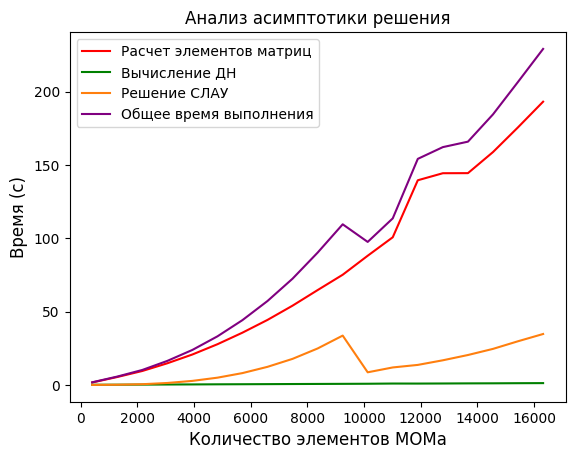

In [ ]:
import matplotlib.pyplot as plt
time_matrix = time_impedance + time_field
#plt.plot(elements_of_mom, time_positions, label = 'calculate positions', color = 'blue')
#plt.yscale('log')
#plt.xscale('log')
plt.plot(elements_of_mom, time_matrix, label = 'Расчет элементов матриц', color = 'red')
plt.plot(elements_of_mom, time_dp, label = 'Вычисление ДН', color = 'green')
plt.plot(elements_of_mom, time_equation, label = 'Решение СЛАУ', color = 'tab:orange')
plt.plot(elements_of_mom, time_matrix+time_dp+time_equation+time_positions, label = 'Общее время выполнения', color = 'purple')
plt.ylabel("Время (с)", size = 12)
plt.xlabel("Количество элементов МОМа", size = 12)
plt.title("Анализ асимптотики решения", size = 12)
plt.legend()

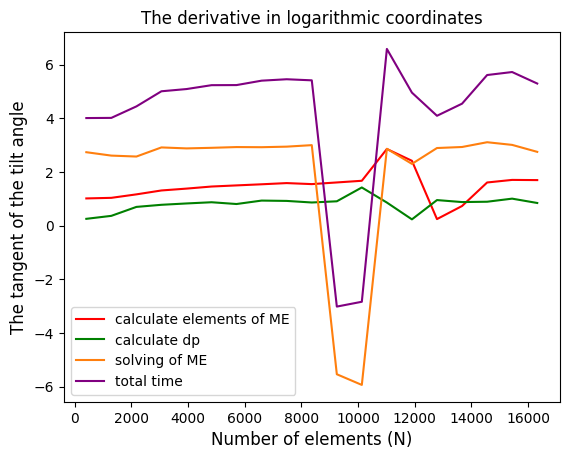

In [ ]:
time_matrix_log = np.log10(time_matrix)
time_equation_log = np.log10(time_equation)
time_dp_log = np.log10(time_dp)

def compute_derivative(x, y):
    
    dydx = np.zeros_like(y)
    dydx[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
    
    dydx[0] = (y[1] - y[0]) / (x[1] - x[0]) 
    dydx[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])
    return dydx

plt.plot(elements_of_mom, compute_derivative(np.log10(elements_of_mom),time_matrix_log), label = 'calculate elements of ME', color = 'red')
plt.plot(elements_of_mom, compute_derivative(np.log10(elements_of_mom),time_dp_log), label = 'calculate dp', color = 'green')
plt.plot(elements_of_mom, compute_derivative(np.log10(elements_of_mom),time_equation_log), label = 'solving of ME', color = 'tab:orange')
plt.plot(elements_of_mom, compute_derivative(np.log10(elements_of_mom),time_equation_log+time_matrix_log+time_dp_log), label = 'total time', color = 'purple')
plt.ylabel("The tangent of the tilt angle", size = 12)
plt.xlabel("Number of elements (N)", size = 12)
plt.title("The derivative in logarithmic coordinates", size = 12)
plt.legend()
